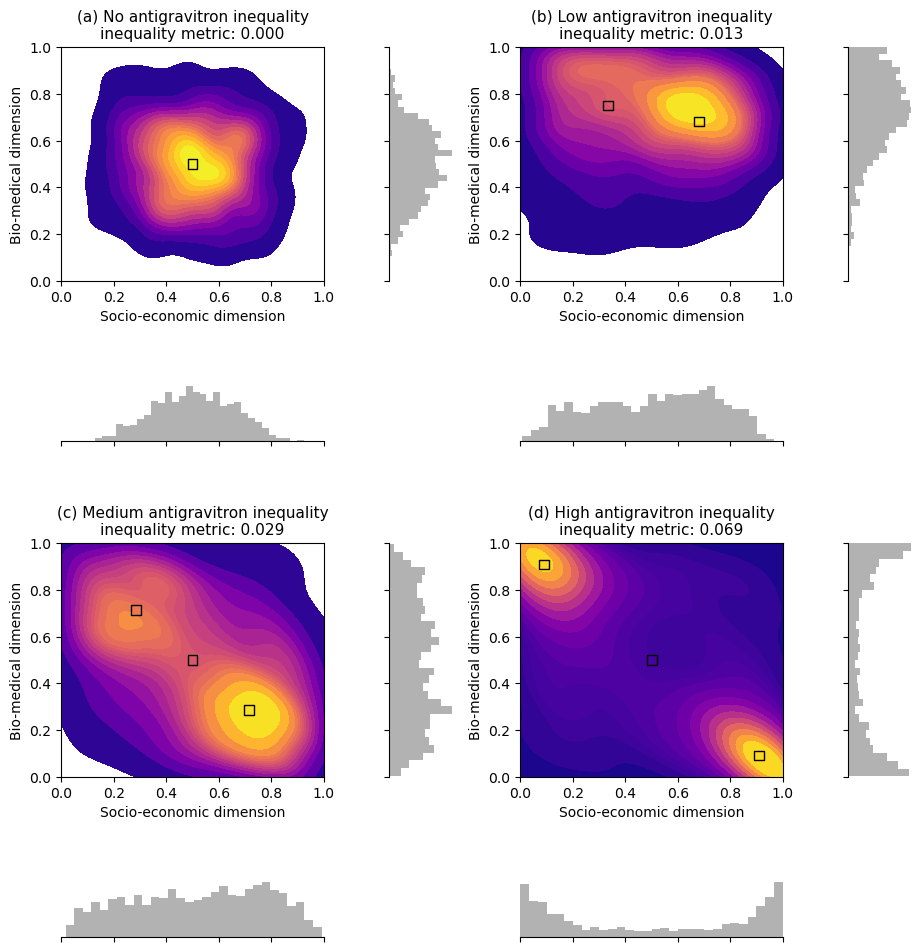

Current directory: c:\2025\07_July\gravitron


In [ ]:
'''
---------------------------------------------------------
Monte Carlos Simulation Experiments of Polarizing 
Inequality based on the Antigravitron
---------------------------------------------------------
Rolando Gonzales Martinez
RUG & Oxford University
2025
---------------------------------------------------------
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import beta, entropy
from scipy.spatial.distance import cdist

np.random.seed(666) # Random seed for reproducibility
simulations = 1000   # Monte Carlo samples

# inequality scenarios:
scenarios = [
    {
        "title": "(a) No antigravitron inequality",
        "pi": np.array([1.0]),
        "alpha": np.array([[5, 5]]),
        "beta": np.array([[5, 5]])
    },
    {
        "title": "(b) Low antigravitron inequality",
        "pi": np.array([0.5, 0.5]),
        "alpha": np.array([[2, 3], [7.5, 7.5]]),
        "beta": np.array([[4, 1], [3.5, 3.5]])
    },
    {
        "title": "(c) Medium antigravitron inequality",
        "pi": np.array([0.3, 0.4, 0.3]),
        "alpha": np.array([[2, 5], [5, 2], [2, 2]]),
        "beta": np.array([[5, 2], [2, 5], [2, 2]])
    },
    {
        "title": "(d) High antigravitron inequality",
        "pi": np.array([0.3, 0.3, 0.4]),
        "alpha": np.array([[1, 10], [10, 1], [1, 1]]),
        "beta": np.array([[10, 1], [1, 10], [1, 1]])
    }
]

# Create the full figure with GridSpec
fig = plt.figure(figsize=(11, 18))
gs = GridSpec(6, 4, figure=fig, wspace=0.4, 
              hspace=0.7, 
              width_ratios=[4, 1, 4, 1], 
              height_ratios=[4, 1, 4, 1, 4, 1])
positions = [(0, 0), (0, 2), (2, 0), (2, 2)]
results = []

for idx, (scenario, (row, col)) in enumerate(zip(scenarios, positions)):
    M = len(scenario["pi"])
    samples = []
    mode_centers = []

    for m in range(M):
        n_m = int(simulations * scenario["pi"][m])
        x = beta.rvs(scenario["alpha"][m, 0], scenario["beta"][m, 0], size=n_m)
        y = beta.rvs(scenario["alpha"][m, 1], scenario["beta"][m, 1], size=n_m)
        samples.append(np.vstack((x, y)).T)
        mode_centers.append([
            scenario["alpha"][m, 0] / (scenario["alpha"][m, 0] + scenario["beta"][m, 0]),
            scenario["alpha"][m, 1] / (scenario["alpha"][m, 1] + scenario["beta"][m, 1])
        ])

    samples = np.vstack(samples)
    mode_centers = np.array(mode_centers)

    modal_entropy = entropy(scenario["pi"])
    concentration = 0
    for m in range(M):
        x = beta.rvs(scenario["alpha"][m, 0], scenario["beta"][m, 0], size=1000)
        y = beta.rvs(scenario["alpha"][m, 1], scenario["beta"][m, 1], size=1000)
        hist2d, _, _ = np.histogram2d(x, y, bins=20, range=[[0, 1], [0, 1]], density=True)
        hist2d_flat = hist2d.flatten() + 1e-10
        ent = entropy(hist2d_flat)
        concentration += scenario["pi"][m] * (1 / ent)

    pairwise_distances = cdist(mode_centers, mode_centers, metric='euclidean')
    weighted_dist = sum(scenario["pi"][i] * scenario["pi"][j] * pairwise_distances[i, j]
                        for i in range(M) for j in range(i + 1, M))
    inequality_metric = modal_entropy * concentration * weighted_dist

    ax_main = fig.add_subplot(gs[row, col])
    sns.kdeplot(
        x=samples[:, 0], y=samples[:, 1], fill=True,
        thresh=0.01, cmap="plasma", levels=16, ax=ax_main
    )
    ax_main.scatter(mode_centers[:, 0], mode_centers[:, 1], c='none', marker="s",
                s=50, edgecolor='black', zorder=3)
    ax_main.set_xlim(0, 1)
    ax_main.set_ylim(0, 1)
    ax_main.set_xlabel("Socio-economic dimension")
    ax_main.set_ylabel("Bio-medical dimension")
    ax_main.set_title(f"{scenario['title']}\ninequality metric: {inequality_metric:.3f}", fontsize=11)

    ax_bottom = fig.add_subplot(gs[row + 1, col], sharex=ax_main)
    ax_bottom.hist(samples[:, 0], bins=30, color='gray', alpha=0.6)
    ax_bottom.set_yticks([])
    ax_bottom.set_xlim(0, 1)
    ax_bottom.set_ylabel('')
    ax_bottom.tick_params(axis='x', labelbottom=False)
    # Remove the box around the histogram
    for spine in ['top', 'left', 'right']:
        ax_bottom.spines[spine].set_visible(False)

    ax_right = fig.add_subplot(gs[row, col+1], sharey=ax_main)  # Changed col+1 to col-1
    ax_right.hist(samples[:, 1], bins=30, color='gray', alpha=0.6, orientation='horizontal')
    ax_right.set_xticks([])
    ax_right.set_ylim(0, 1)
    ax_right.set_xlabel('')
    ax_right.tick_params(axis='y', labelleft=False)
    # Remove the box around the histogram (keep left spine if needed)
    for spine in ['top', 'bottom', 'right']:
        ax_right.spines[spine].set_visible(False)

plt.show()
# Save the figure
import os

# Get current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)
fig.savefig("MCsim_antigravitron.png", dpi=600, bbox_inches='tight')